## Assignment A2b: Photon Detection

### David Courtney 3643806


In [27]:
using Distributions, Plots, Random

# 1A
function randtimes(N; t1, t2)
    return t1 .+ (t2 - t1) .* rand(N)
end

# 1A
function plotflash(times; t1, t2, size=(600, 150))
    y = ones(length(times))
    scatter(times, y, label="Photon Arrival", color=:green, marker=:circle, size=size)
    for time in times
        plot!([time, time], [0, 1], color="#95B9E1", label="", legend=false)
    end
    #xlabel!("Time (s)")
    xlabel!("")
    #ylabel!("Photon Event")
    ylabel!("")
    title!("Photon Arrival Times")
    xlims!(t1, t2)
    ylims!(0, 1.2)
end


# 1B
function randintervals(N; lambda=lambda, t1=t1)
    intervals = rand(Exponential(1/lambda), N)
    times = cumsum(intervals) .+ t1
    return times
end


# 2A
function poisson_probabilities(lambda, T, n_max)
    n_values = 0:n_max
    probabilities = [(lambda * T)^n / factorial(n) * exp(-lambda * T) for n in n_values]
    return n_values, probabilities
end

# 2B / 3B / 3C
function prob_detect_or_see(K; lambda=nothing, T=nothing, I=nothing, alpha=nothing)
    effective_rate = if lambda !== nothing && T !== nothing
        lambda * T
    elseif I !== nothing && alpha !== nothing
        alpha * I
    else
        error("Invalid parameters. You must specify either (lambda and T) or (I and alpha).")
    end
    
    poisson_dist = Poisson(effective_rate)
    prob = 1 - cdf(poisson_dist, K - 1)
    return prob
end

# 2B
function detectionprob(K; lambda=40, T=0.1)
    return prob_detect_or_see(K; lambda, T)
end

# 3A
function lightflash(lambda; f1=0.8, f2=2.2)
    n_photons = rand(Poisson(lambda * (f2 - f1)))
    photon_times = sort(f1 .+ (f2 - f1) .* rand(n_photons))
    return photon_times
end

# 3A
function apply_shutter(photon_times, s1, s2)
    return filter(t -> s1 <= t <= s2, photon_times)
end

# 3A
function detect_photons(photon_times, alpha)
    detected = filter(_ -> rand() < alpha, photon_times)
    return detected
end

# 3A
function photon_stream_fig(;lambda=100, alpha=0.06, f1=0.8, f2=2.2, s1=1, s2=2)

    photon_stream = lightflash(lambda; f1=f1, f2=f2)
    photons_through_shutter = apply_shutter(photon_stream, s1, s2)
    detected_photons = detect_photons(photons_through_shutter, alpha)

    p1 = scatter(photon_stream, ones(length(photon_stream)), label="Stream",
                title="Photon Stream", xlims=(f1, f2), ylims=(0.98, 1.01),
                yticks=false, marker=:circle, markersize=2, legend=:topright)
                for x in photon_stream
                    plot!([x, x], [0, 1], color=:blue, legend=false) # Assuming the color you want is blue
                end
    p2 = scatter(photons_through_shutter, ones(length(photons_through_shutter)), label="Through Shutter",
                title="Photons through Shutter", xlims=(f1, f2), ylims=(0.98, 1.01),
                yticks=false, marker=:circle, markersize=2, legend=:topright)
                for x in photons_through_shutter
                    plot!([x, x], [0, 1], color=:green, legend=false) # Assuming the color you want is green
                end
    p3 = scatter(detected_photons, ones(length(detected_photons)), label="Detected",
                title="Detected Photons", xlims=(f1, f2), ylims=(0.98, 1.01),
                yticks=false, marker=:circle, markersize=2, legend=:topright)
                for x in detected_photons
                    plot!([x, x], [0, 1], color=:red, legend=false) # Assuming the color you want is red
                end

    plot(p1, p2, p3, layout=(3, 1), xlabel="", xticks=(f1:0.5:f2), size=(600, 400), 
        plot_title="")
end

# 3B
function probseeing(I; alpha=0.06, K=6)
    return prob_detect_or_see(K; I=I, alpha=alpha)
end

# 3C
function plotdetectioncurve(;alphas=[0.5], Ks=[6], I_range=(0.01, 100), points=100)
    xs = exp10.(range(log10(I_range[1]), log10(I_range[2]), length=points))
    
    plot(xscale=:log10, xlabel="Intensity I", ylabel="Percentage Detected", 
         title="Detection Curve", legend=:topleft, xlims=I_range, ylims=(0, 100))
    
    for alpha in alphas
        for K in Ks
            ys = [prob_detect_or_see(K; I=x, alpha=alpha) for x in xs] .* 100
            plot!(xs, ys, label="α=$alpha, K=$K")
        end
    end
    plot!()
end

# 3D
function plotfit(;alpha=0.01, K=6)
    I_range = (10, 250)
    points = 100
    xs = exp10.(range(log10(I_range[1]), log10(I_range[2]), length=points))
    
    p = plot(xscale=:log10, xlabel="photons at cornea", ylabel="% flashes detected",
             title="", legend=:topleft, xlims=I_range, ylims=(0, 110),
             xticks=([10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80., 90.0, 100.0, 200.0], ["10.0", "", "", "", "", "", "", "", "", "100.0", ""]),
             size=(400, 400))
    
    ys_new1 = [prob_detect_or_see(2; I=x, alpha=0.02) for x in xs] * 100
    plot!(p, xs, ys_new1, label="Model: α=0.02, K=2", linewidth=2, linestyle=:dash, color=:blue)

    ys = [prob_detect_or_see(K; I=x, alpha=alpha) for x in xs] * 100
    plot!(p, xs, ys, label="Model: α=$alpha, K=$K", linewidth=2, linestyle=:solid, color=:orange)

    ys_new2 = [prob_detect_or_see(12; I=x, alpha=0.13) for x in xs] * 100
    plot!(p, xs, ys_new2, label="Model: α=0.13, K=12", linewidth=2, linestyle=:dash, color=:green)        

    # HSP subject SS data
    I_data = [24.1, 37.6, 58.6, 91.0, 141.9, 221.3]
    percentage_seen = [0.0, 4.0, 18.0, 54.0, 94.0, 100.0]
    scatter!(p, I_data, percentage_seen, label="HSP SS Data", color=:white, markersize=3, markeralpha=0.6)
    
    return p
end


plotfit (generic function with 1 method)

### 1a. Random times


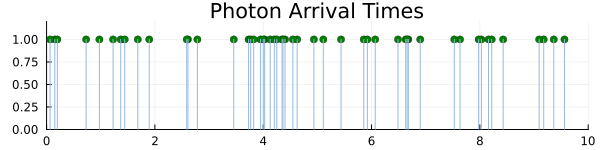

In [28]:
# Sample data
N     = 50
t1    = 0
t2    = 10
times = randtimes(N; t1=t1, t2=t2)

plotflash(times; t1, t2)


### 1b. Random intevals

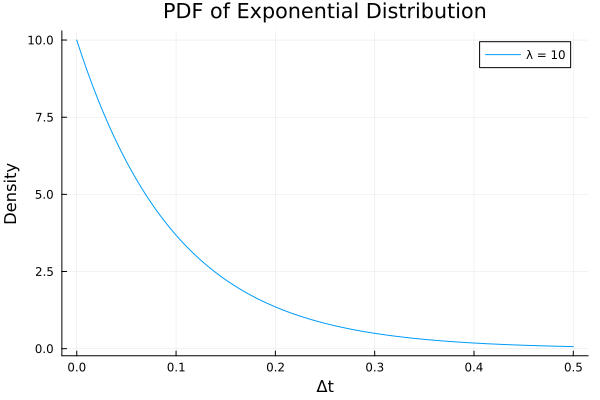

In [29]:
lambda = 10
pdf_exponential(delta_t, lambda) = lambda * exp(-lambda * delta_t)
delta_t_values = range(0, stop=1/lambda*5, length=1000)
pdf_values = pdf_exponential.(delta_t_values, lambda)
plot(delta_t_values, pdf_values, label="λ = 10", xlabel="Δt", ylabel="Density", title="PDF of Exponential Distribution")


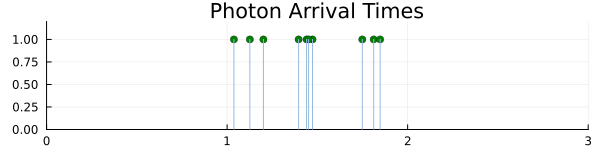

In [30]:
# Parameters
N = 10
t1 = 1
t2 = 2

times = randtimes(N; t1=t1, t2=t2)
plotflash(times; t1=0, t2=3)

### 1c. Seeing the flash

The two methods for simulating photon arrival times differ in how they model the process:

1. **Uniform Distribution Method**: Generates events uniformly across a time interval, simplifying the process but not accurately reflecting the random nature of photon arrivals.

2. **Exponential Distribution Method**: Simulates the time between successive events using an exponential distribution, closely mirroring the actual random, independent occurrence of photons in a Poisson process.

The detection of light flashes is probabilistic because:

- **Quantum variability**: Photons behave unpredictably; their arrival and detection are subject to quantum randomness.
- **Detection threshold**: A minimum number of photons must be detected within a certain timeframe to differentiate a light flash from background noise, due to the sensory system's limitations and internal noise.
- **Random arrival**: Photon arrival follows a Poisson process, making the number of photons detected in any interval inherently random.

In summary, the probabilistic nature of detecting flashes arises from the random arrival of photons, quantum uncertainty, and the sensory system's need to distinguish signal from noise.

### 2a. The probability of K photons

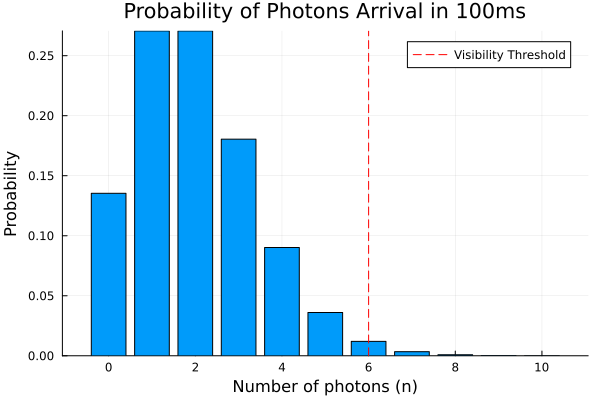

In [31]:
# Sample Parameters
lambda      = 20
T           = 0.1  # observation period in seconds
n_max       = 10   # maximum number of photons to calculate probabilities for
v_threshold = 6    # (visible threshold) minimum number of photons for visibility

n_values, probabilities = poisson_probabilities(lambda, T, n_max)

bar_plot = bar(n_values, probabilities, legend=:topright, xlabel="Number of photons (n)", ylabel="Probability",
    title="Probability of Photons Arrival in 100ms", label=false, xticks=0:2:n_max)

visible_indices = findall(x -> x >= v_threshold, n_values)

# Adding visibility threshold indicator
vline!([v_threshold], linestyle=:dash, color=:red, label="Visibility Threshold")

display(bar_plot)


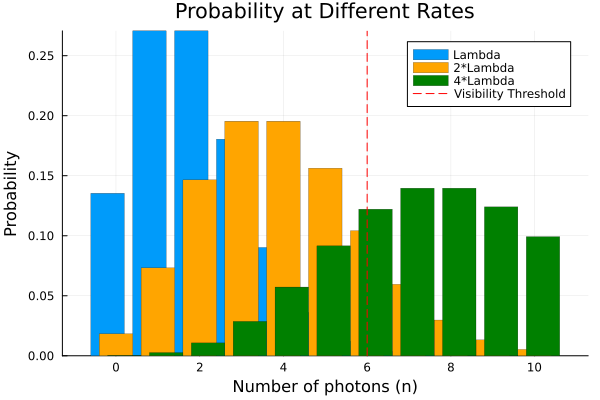

In [32]:
# Sample Parameters
lambda      = 20
T           = 0.1  # observation period in seconds
n_max       = 10   # maximum number of photons to calculate probabilities for
v_threshold = 6    # (visible threshold) minimum number of photons for visibility

# Calculate probabilities for the initial, double, and quadruple rates
n_values, probabilities_initial = poisson_probabilities(lambda * 1, T, n_max)
_, probabilities_double         = poisson_probabilities(lambda * 2, T, n_max)
_, probabilities_quadruple      = poisson_probabilities(lambda * 4, T, n_max)

# Plotting
bar_plot = bar(n_values .- 0.2, probabilities_initial, width=0.2, label="Lambda", legend=:topright,
               xlabel="Number of photons (n)", ylabel="Probability", 
               title="Probability at Different Rates", xticks=0:2:n_max)
bar!(n_values, probabilities_double, width=0.2, label="2*Lambda", color=:orange)
bar!(n_values .+ 0.2, probabilities_quadruple, width=0.2, label="4*Lambda", color=:green)

# Adding visibility threshold indicator
vline!([v_threshold], linestyle=:dash, color=:red, label="Visibility Threshold")

display(bar_plot)


### 2b. The probability of K or more photons

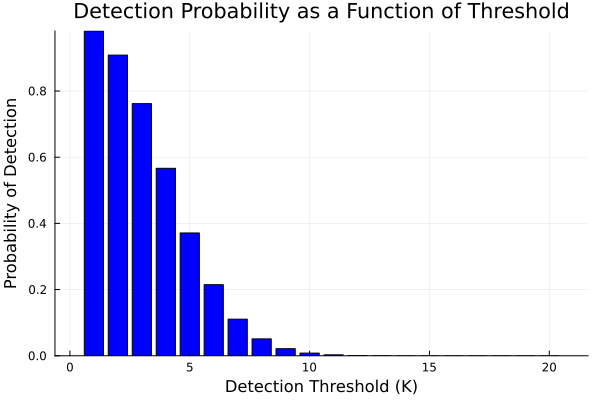

In [33]:
# Parameters
lambda = 40  # Example rate
T      = 0.1  # Observation period in seconds
K_max  = 20  # Maximum threshold to consider

# Calculate detection probabilities for thresholds from 1 to K_max
K_values = 1:K_max
probabilities = [detectionprob(K; lambda=lambda, T=T) for K in K_values]

# Plotting
bar_plot = bar(K_values, probabilities, legend=false, xlabel="Detection Threshold (K)", ylabel="Probability of Detection",
    title="Detection Probability as a Function of Threshold", color=:blue)

display(bar_plot)


### 3a. Simulating the photon stream



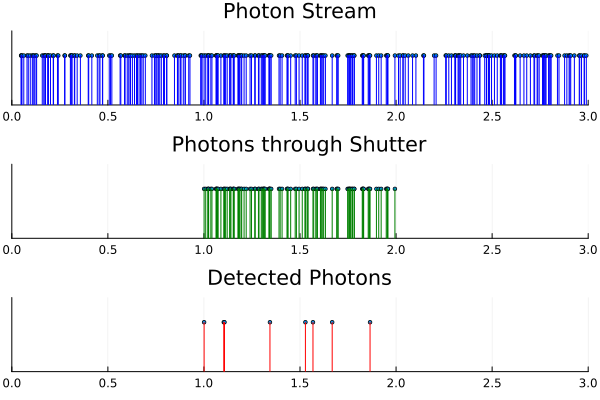

In [34]:
# Sample Parameters
lambda = 100       # Photon rate per millisecond
f1, f2 = 0.0, 3.0  # Start and stop times in milliseconds for the photon stream
s1, s2 = 1.0, 2.0  # Shutter open and close times in milliseconds
alpha  = 0.06      # Detection probability

photon_stream_fig(lambda=lambda, alpha=alpha, f1=f1, f2=f2, s1=s1, s2=s2)


### 3b. Probability of seeing


In [35]:
# Sample parameters
I = 300
prob = probseeing(I)
println("Probability of seeing: ", prob)

Probability of seeing: 0.9996760065488989


### 3c. Plotting % detected vs light intensity for different parameters

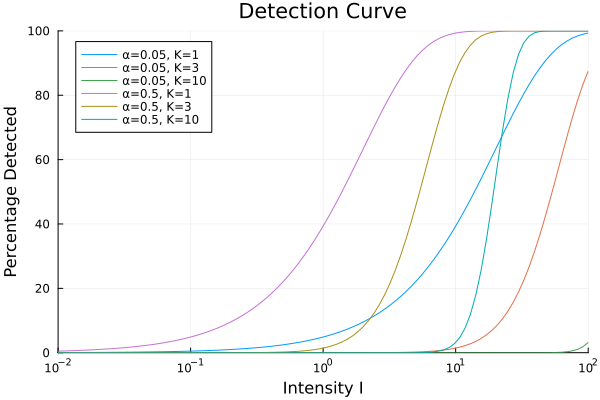

In [36]:
plotdetectioncurve(alphas=[0.05, 0.5], Ks=[1, 3, 10], I_range=(.01, 100))


### 3d. Fitting parameters to experimental data

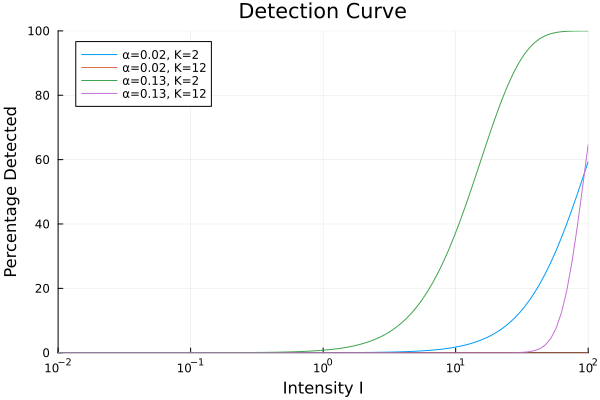

In [37]:
plotdetectioncurve(alphas=[0.02, 0.13], Ks=[2, 12], I_range=(.01, 100))


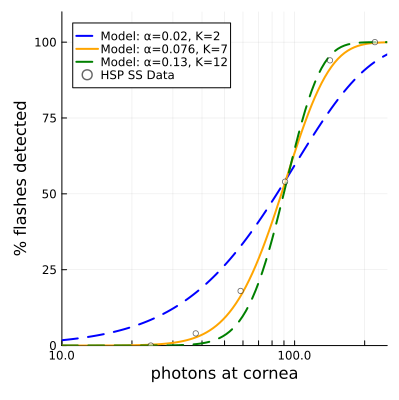

In [38]:
# Optimal values plot
display(plotfit(alpha=0.076, K=7))


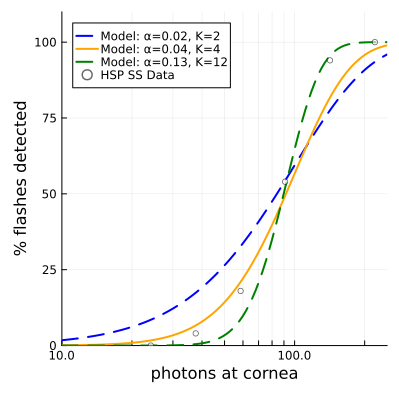

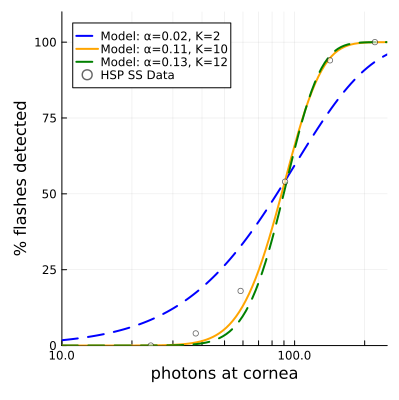

In [39]:
# Sub-optimal values plots
display(plotfit(alpha=0.04, K=4))
display(plotfit(alpha=0.11, K=10))


Seeing a dim flash of light involves the following key points:

1. **Photon Arrival**: A certain number of photons must reach the eye. Not all photons emitted by a source will make it to the retina.

2. **Absorption**: Photoreceptor cells (rods) in the eye must absorb these photons. Only a fraction of arriving photons are absorbed, determined by the absorption rate ($\alpha$).

3. **Detection Threshold**: There's a minimum number of photons ($K$) that must be absorbed within a short time frame for the flash to be perceived. This threshold varies but can be very low, often just a few photons under ideal conditions.

4. **Statistical Nature**: The process is probabilistic, governed by factors like the absorption rate and the physiological noise in the eye's photoreceptors.

In essence, detecting a dim flash of light is a combination of the number of photons reaching the eye, the efficiency of the eye in absorbing those photons, and the statistical likelihood of those photons being enough to surpass the sensory threshold for perception.

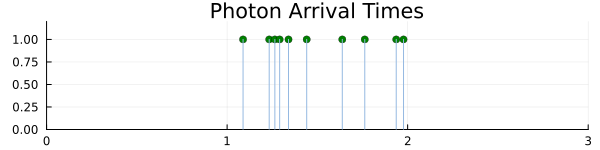

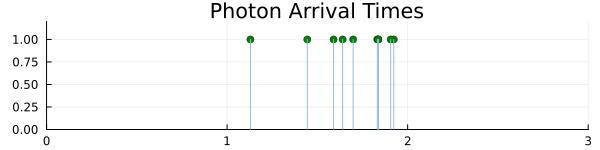

In [40]:
# Question 1

# Parameters
N  = 10
t1 = 1
t2 = 2

t = randtimes(N; t1=t1, t2=t2)
p1 = plotflash(t; t1=0, t2=3)

t = randtimes(N; t1=t1, t2=t2)
p2 = plotflash(t; t1=0, t2=3)

display(p1)
display(p2)

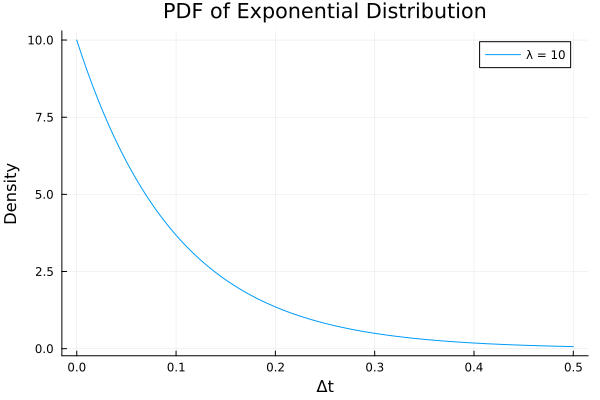

In [41]:
# Question 2 (Copy of 1B)
lambda = 10
pdf_exponential(delta_t, lambda) = lambda * exp(-lambda * delta_t)
delta_t_values = range(0, stop=1/lambda*5, length=1000)
pdf_values = pdf_exponential.(delta_t_values, lambda)
plot(delta_t_values, pdf_values, label="λ = 10", xlabel="Δt", ylabel="Density", title="PDF of Exponential Distribution")

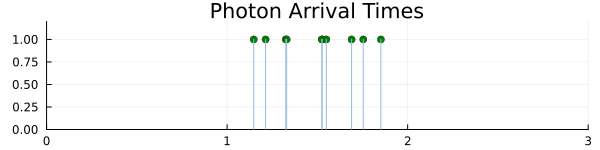

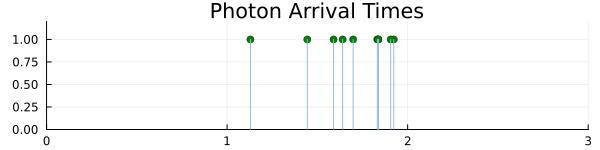

In [42]:
# Question 3

# Parameters
N      = 10
lambda = 10
t1     = 1
t2     = 2

t = randintervals(N; lambda=lambda, t1=t1)
p1 = plotflash(t; t1=0, t2=3)

t = randintervals(N; lambda=lambda, t1=t1)
p1 = plotflash(t; t1=0, t2=3)

display(p1)
display(p2)

In [43]:
# Question 4
lambda = 10   # Rate
T      = 0.1  # observation period in seconds
n_max  = 3    # maximum number of photons to calculate probabilities for

n_values, probabilities = poisson_probabilities(lambda, T, n_max)

for (n, prob) in zip(n_values, probabilities)
    println("Probability of receiving $n photons in $T seconds: $prob")
end

Probability of receiving 0 photons in 0.1 seconds: 0.36787944117144233
Probability of receiving 1 photons in 0.1 seconds: 0.36787944117144233
Probability of receiving 2 photons in 0.1 seconds: 0.18393972058572117
Probability of receiving 3 photons in 0.1 seconds: 0.061313240195240384


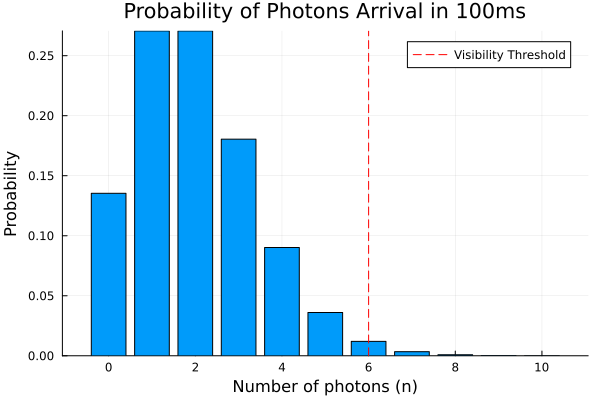

In [44]:
# Question 5
lambda      = 20
T           = 0.1  # observation period in seconds
n_max       = 10   # maximum number of photons to calculate probabilities for
v_threshold = 6    # (visible threshold) minimum number of photons for visibility

n_values, probabilities = poisson_probabilities(lambda, T, n_max)

bar_plot = bar(n_values, probabilities, legend=:topright, xlabel="Number of photons (n)", ylabel="Probability",
    title="Probability of Photons Arrival in 100ms", label=false, xticks=0:2:n_max)

visible_indices = findall(x -> x >= v_threshold, n_values)

# Adding visibility threshold indicator
vline!([v_threshold], linestyle=:dash, color=:red, label="Visibility Threshold")

display(bar_plot)

In [45]:
# Question 6
detectionprob(6; lambda=40, T=0.1)

0.21486961296959461

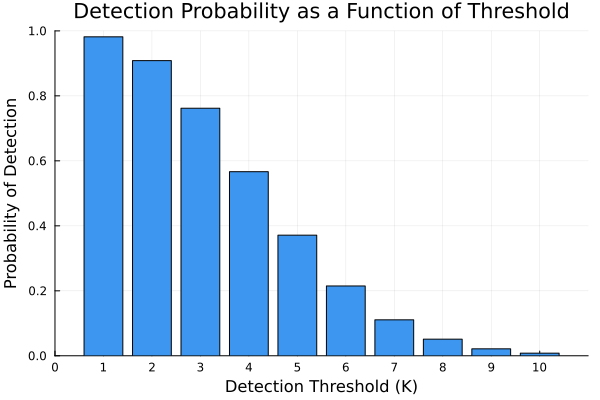

In [46]:
# Question 7

# Parameters
lambda = 40   # Rate
T      = 0.1  # Observation period in seconds
K_max  = 10   # Maximum threshold to consider

# Calculate detection probabilities for thresholds from 1 to K_max
K_values = 1:K_max
probabilities = [detectionprob(K; lambda=lambda, T=T) for K in K_values]

# Plotting
bar_plot = bar(K_values, probabilities, legend=false, xlabel="Detection Threshold (K)", ylabel="Probability of Detection",
    title="Detection Probability as a Function of Threshold", color="#3D97F1",
    ylim=(0,1),
    xlims=(0,11),
    xticks=0:1:10)

display(bar_plot)

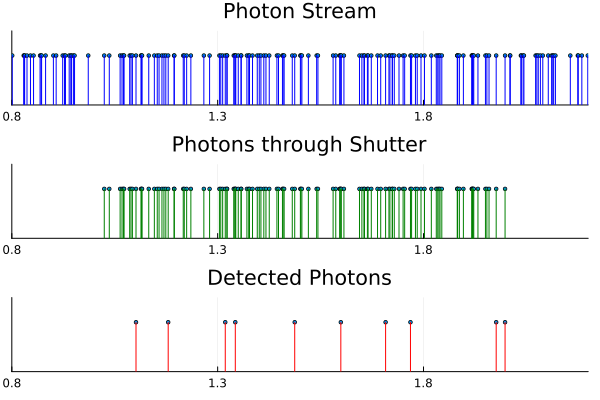

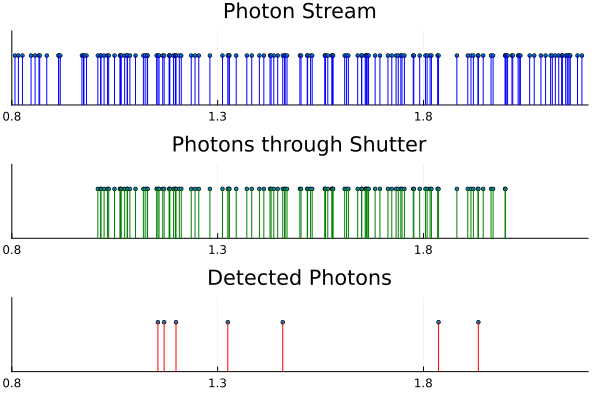

In [47]:
# Question 8

# Parameters
lambda = 100       # Photon rate per millisecond
f1, f2 = 0.8, 2.2  # Start and stop times in milliseconds for the photon stream
s1, s2 = 1.0, 2.0  # Shutter open and close times in milliseconds
alpha  = 0.06      # Detection probability

p1 = photon_stream_fig(lambda=lambda, alpha=alpha, f1=f1, f2=f2, s1=s1, s2=s2)
p2 = photon_stream_fig(lambda=lambda, alpha=alpha, f1=f1, f2=f2, s1=s1, s2=s2)

display(p1)
display(p2)


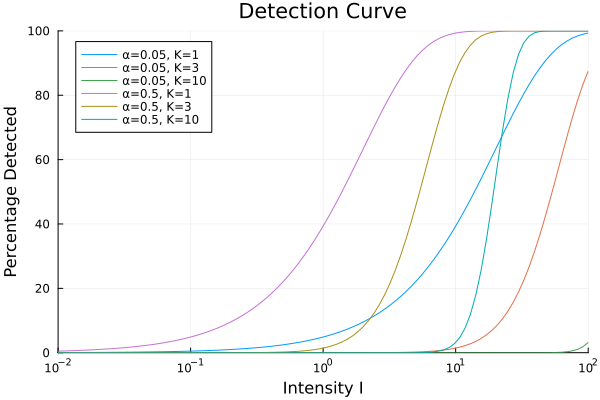

In [48]:
# Question 9 (Copy of 3C)
plotdetectioncurve(alphas=[0.05, 0.5], Ks=[1, 3, 10], I_range=(.01, 100))

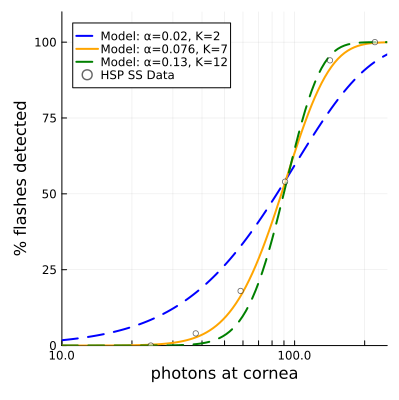

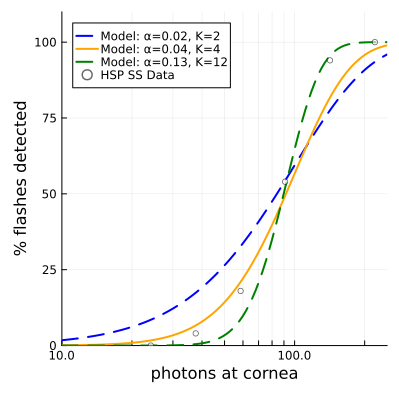

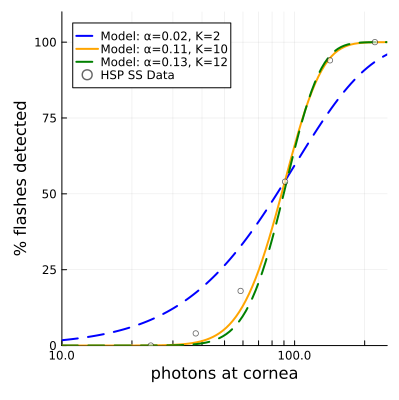

In [49]:
# Question 10 (Copy of 3D)

# Optimal values plot
display(plotfit(alpha=0.076, K=7))

# Sub-optimal values plots
display(plotfit(alpha=0.04, K=4))
display(plotfit(alpha=0.11, K=10))


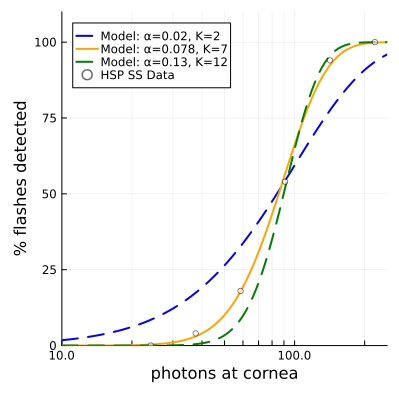

In [50]:
# Question 11

# Optimal values plot
display(plotfit(alpha=0.078, K=7))


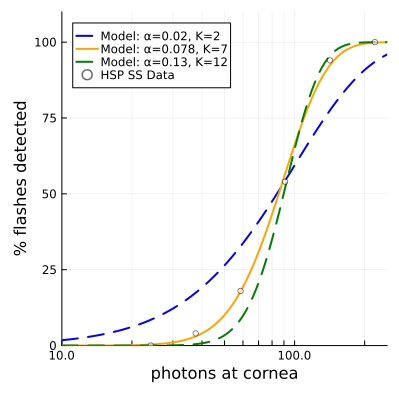

In [51]:
# Question 12

# Optimal values plot
display(plotfit(alpha=0.078, K=7))

In [52]:
# Question 13
#
# Multiple Choice Question